# Parameter Inference With Bioscrape

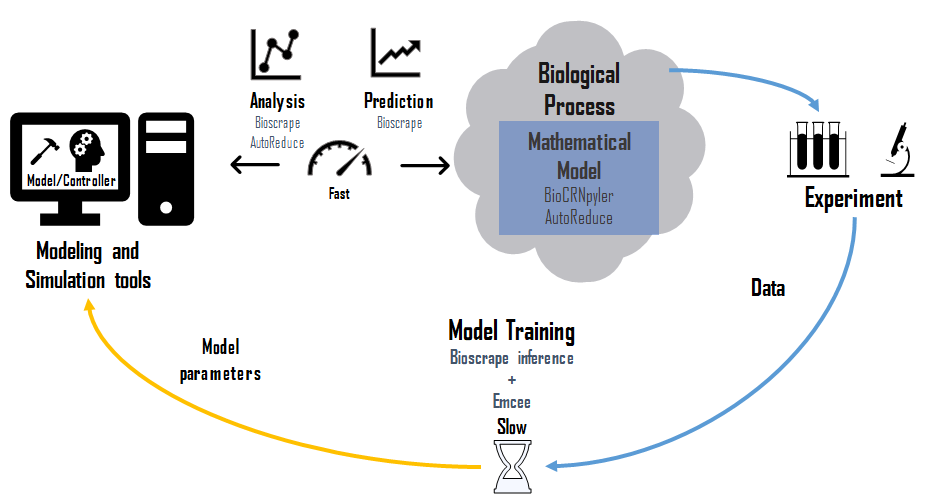

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import bioscrape as bs

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Uncomment if Helvetica font face is installed 
# mpl.rcParams['font.family'] = 'Helvetica'

tw = 1.5

sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 16, 'axes.titlesize': 16,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5, titlesize=14, labelsize=14)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(8.5,15))

## Load data and create dataframe

To get started with parameter identification, we load the data file from Github:

## Pre-process the CSV from Echo or Biotek

In [2]:
import pandas as pd
import numpy as np

def time_in_minutes(t):
    ans = t.hour*60+t.minute+t.second/60.0+t.microsecond / 1000000.0 / 60.0
    if type(t).__name__ == 'datetime':
        ans += t.day * 24*60
    return ans
        
csv_data = pd.read_csv('../experimental_data/20220425_2D_Dilution_Int_Reporter_Biotek1_tidy.csv')

# Data arrays:
num_integrase_conditions = 5
num_reporter_conditions = 5
num_replicates = 2
biotek_gain = 100

# All time points are the same, so just get one set of times for a given condition and measurement
chosen_well = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Rep (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain))]['Well'])[0]
timepoints = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))& (csv_data['Int (nM)'].eq(1))\
                       & (csv_data['Rep (nM)'].eq(1))\
                       & (csv_data['Gain'].eq(biotek_gain)) & (csv_data['Well'].eq(chosen_well))]['Time (hr)']*60)
real_timepoints = timepoints

num_timepoints = np.shape(timepoints)[0]
full_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )
full_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )

back_cfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )
back_yfp = np.empty( (num_timepoints, num_replicates , num_integrase_conditions , num_reporter_conditions ) )

int_conditions = [0, 0.25, 0.5, 0.75, 1]
rep_conditions = [0, 0.25, 0.5, 0.75, 1]

for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for rep_nm,rep_ind in zip(rep_conditions,range(num_reporter_conditions)):
        for repl in range(num_replicates):
            replicate = repl+1
            full_cfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('deCFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement'])# calibration factors / 13809. * 1000.0
            back_cfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('deCFP'))\
                                                                   & (csv_data['Int (nM)'].eq(0))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement'])# calibration factors / 13809. * 1000.0
            full_yfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(rep_nm))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement']) # calibration factors / 50405. * 1000.0
            back_yfp[:,repl,int_ind,rep_ind] = np.array(csv_data.loc[(csv_data['Channel'].eq('YFP'))\
                                                                   & (csv_data['Int (nM)'].eq(int_nm))\
                                                                   & (csv_data['Rep (nM)'].eq(0))\
                                                                   & (csv_data['Gain'].eq(biotek_gain))\
                                                                   & (csv_data['Replicate'].eq(replicate))\
                                                                   & (csv_data['deGFP Positive Control (nM)'].eq(0))]\
                                                      ['Measurement']) # calibration factors / 50405. * 1000.0


# Calibrate to concentration (using: https://biocircuits.cds.caltech.edu/TXTL-calibration#Biotek_Calibration_4/22/2022_Makena)
# Linear fit: RFU measurement = slope*concentration in uM + intercept
# So, concentration (in nM) = 1000*(RFU - intercept)/slope
if biotek_gain == 61:
    cfp_slope = 456.71
#     cfp_intercept = -384.26
    cfp_intercept = 0
    yfp_slope = 993.69
#     yfp_intercept = 468.56
    yfp_intercept = 0

if biotek_gain == 100:
    cfp_slope = 12796.23
    cfp_intercept = -6248.64 
#     cfp_intercept = 0
    yfp_slope = 44451.55
#     yfp_intercept = 294
    yfp_intercept = 0

for int_nm,int_ind in zip(int_conditions,range(num_integrase_conditions)):
    for rep_nm,rep_ind in zip(rep_conditions,range(num_reporter_conditions)):
        for repl in range(num_replicates):
            full_cfp[:,repl,int_ind,rep_ind] = 1000*(1/cfp_slope)*(full_cfp[:,repl,int_ind,rep_ind] - cfp_intercept)
            back_cfp[:,repl,int_ind,rep_ind] = 1000*(1/cfp_slope)*(back_cfp[:,repl,int_ind,rep_ind] - cfp_intercept)
            full_yfp[:,repl,int_ind,rep_ind] = 1000*(1/yfp_slope)*(full_yfp[:,repl,int_ind,rep_ind] - yfp_intercept)
            back_yfp[:,repl,int_ind,rep_ind] = 1000*(1/yfp_slope)*(back_yfp[:,repl,int_ind,rep_ind] - yfp_intercept)
#Process the background.
for rep_ind in range(num_reporter_conditions):
    for int_ind in range(num_integrase_conditions):
        full_cfp[:,:,int_ind,rep_ind] = np.maximum(full_cfp[:,:,int_ind,rep_ind] - back_cfp[:,:,int_ind,rep_ind], 0)
        full_yfp[:,:,int_ind,rep_ind] = np.maximum(full_yfp[:,:,int_ind,rep_ind] - back_yfp[:,:,int_ind,rep_ind], 0)

## Plot experimental data

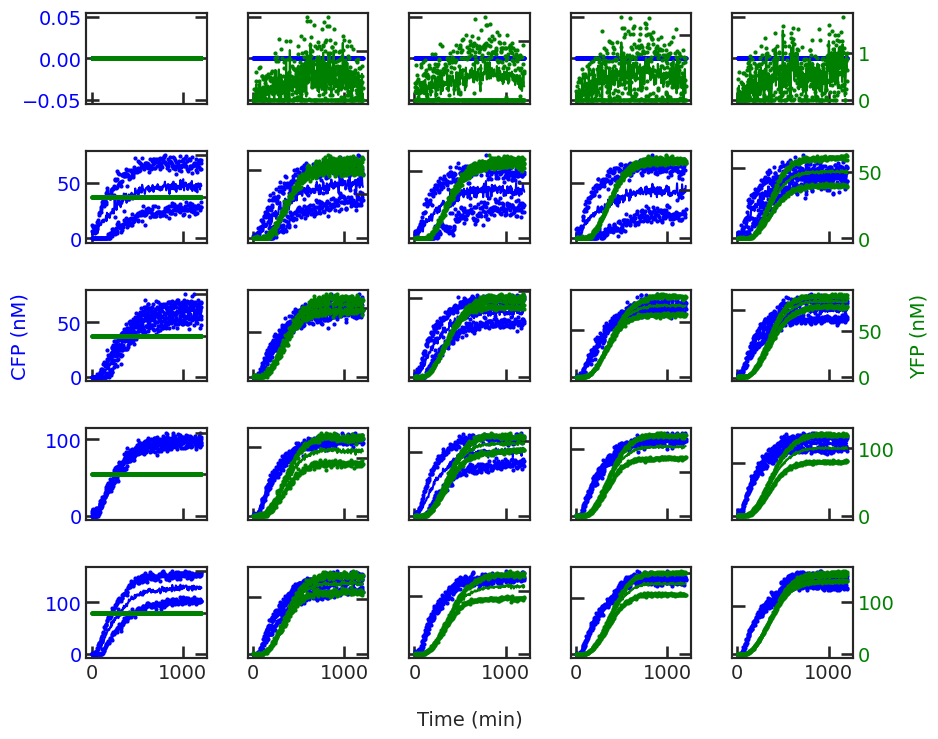

In [3]:
figsize = (10,8)
figc = plt.figure(figsize=figsize)

current_index = 1

cfp_median = np.empty((num_timepoints,num_integrase_conditions,num_reporter_conditions))
yfp_median = np.empty((num_timepoints,num_integrase_conditions,num_reporter_conditions))

for int_ind in range(num_integrase_conditions):
    for rep_ind in range(num_reporter_conditions):
        cfp_median[:,int_ind,rep_ind] = np.mean(full_cfp[:,:,int_ind, rep_ind],axis=1)
        axc = figc.add_subplot(num_integrase_conditions,num_reporter_conditions,current_index)
        axc.plot(timepoints,cfp_median[:,int_ind,rep_ind], 'b-')
        axc.plot(timepoints,full_cfp[:,:,int_ind, rep_ind], 'b.', markersize=4)
        for tl in axc.get_yticklabels():
            tl.set_color('b')
        
        axy = axc.twinx()
        yfp_median[:,int_ind,rep_ind] = np.mean(full_yfp[:,:,int_ind, rep_ind],axis=1)
        axy.plot(timepoints, yfp_median[:,int_ind,rep_ind], 'g-')
        axy.plot(timepoints, full_yfp[:,:,int_ind,rep_ind], 'g.', markersize=4)
        for tl in axy.get_yticklabels():
            tl.set_color('g')      
        if rep_ind > 0:
            axc.set_yticklabels([])
        if rep_ind < num_reporter_conditions - 1:
            axy.set_yticklabels([])
        if int_ind < num_integrase_conditions - 1:
            axy.set_xticklabels([])
        
        if int_ind == num_integrase_conditions - 1 and rep_ind ==  num_reporter_conditions//2:
            axc.set_xlabel('Time (min)',labelpad=20)
        if rep_ind == 0 and int_ind ==  num_integrase_conditions//2:
            axc.set_ylabel('CFP (nM)',color='b',labelpad=20)
        if rep_ind ==  num_reporter_conditions - 1 and int_ind ==  num_integrase_conditions//2:
            axy.set_ylabel('YFP (nM)', color='g',labelpad=20)
        current_index += 1

figc.tight_layout()

In [4]:
initial_conditions = []
all_data = []
expdata_dict = {}
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,rep_nm,'CFP')] = cfp_median[:,int_ind,rep_ind]
        expdata_dict[(int_nm,rep_nm,'YFP')] = yfp_median[:,int_ind,rep_ind]
        all_data.append(expdata_dict)

In [5]:
timepoints[:180][-1]

898.2

/tmp/ipykernel_9477/2032844555.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


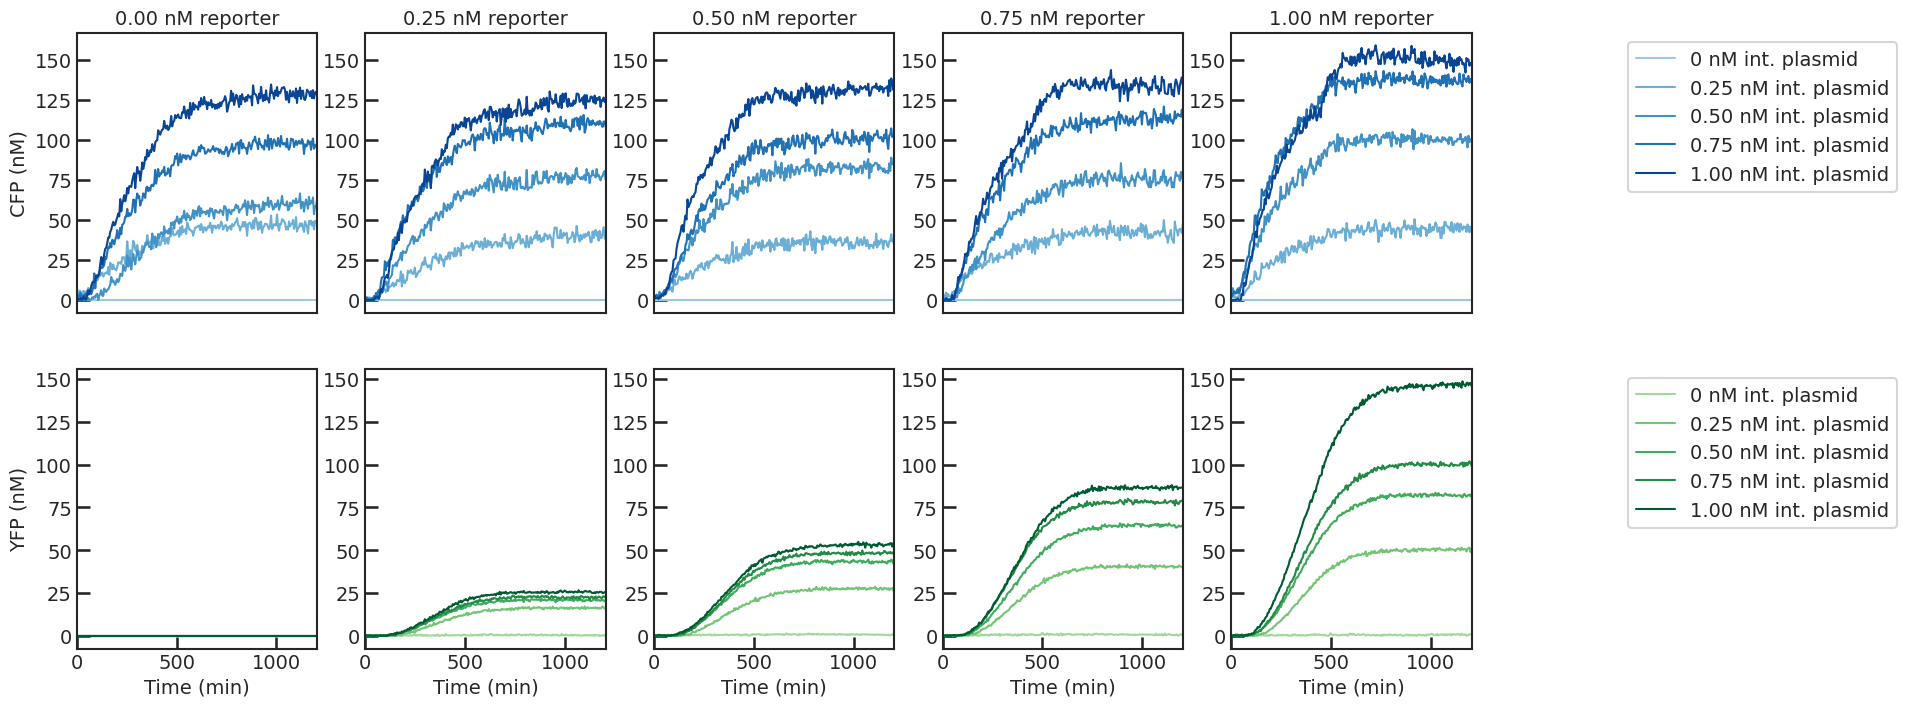

In [6]:
import numpy as np
import matplotlib.pyplot as plt
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
time_lim = (0,timepoints[-1]+1)
cfp_lim = (0,65)
yfp_lim = (0,200)
figsize = (18,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
    
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
    axc.set_xlim(time_lim)
    axy.set_xlim(time_lim)
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
    axc.set_xticks([])

    index += 1

fig.tight_layout()
# fig.savefig('../outputs/integrase-raw-data.svg')

## Truncate data to 600 minutes:

We truncate the experimental data to 600 minutes as that is the time-period of interest and our model does not capture the leveling out of the fluorescence reporter amounts.

/tmp/ipykernel_9477/778499580.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


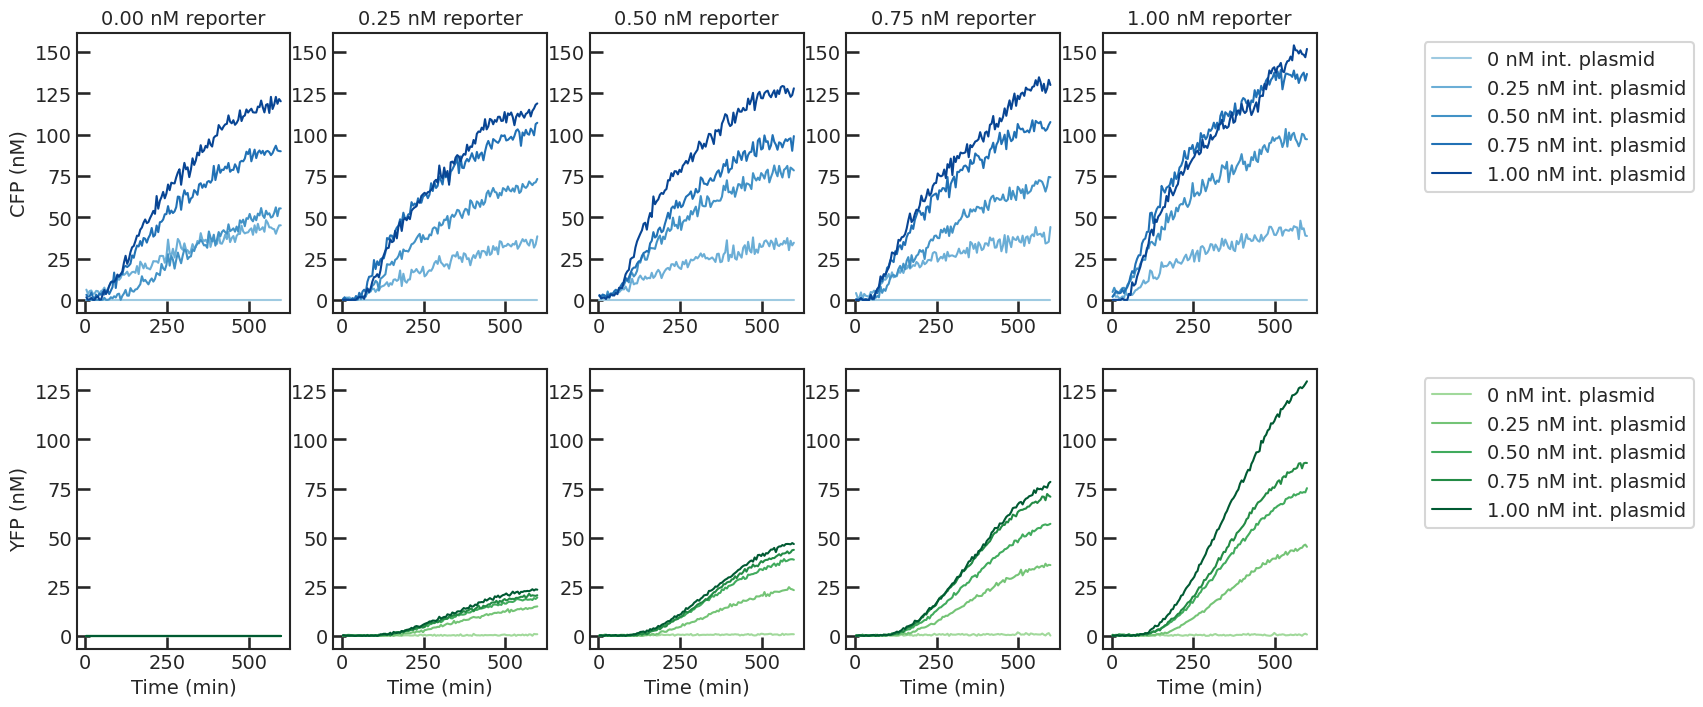

In [7]:
initial_conditions = []
all_data = []
expdata_dict = {}
timepoints = real_timepoints[:120]
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        expdata_dict[(int_nm,rep_nm,'CFP')] = cfp_median[:120,int_ind,rep_ind]
        expdata_dict[(int_nm,rep_nm,'YFP')] = yfp_median[:120,int_ind,rep_ind]
        all_data.append(expdata_dict)

colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']

plt.close()
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind] )
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
    index += 1

fig.tight_layout()
# fig.savefig('../outputs/integrase-data-processed.svg')

# Run bioscrape inference

To identify parameter distributions, we run bioscrape inference for the example above. The three main ingredients of this black-box parameter inference pipeline are:

1. Experimental data as a `Pandas` dataframe (or a list of Dataframes) consisting of the measurements as columns along with a "time" column.
2. An SBML file that models the system we want to identify.
3. Prior information about parameters. 

We already have the experimental data as a list of Pandas dataframe above corresponding to a list of initial conditions. So, for the second step, we load the SBML file of the reduced model below:

In [8]:
from bioscrape.inference import py_inference
from bioscrape.types import Model
from bioscrape.simulator import *
import numpy as np
import pickle
import time

# time_lim = (0,600)
int_levels = [0,0.25,0.5,0.75,1.]
rep_levels = [0,0.25,0.5,0.75,1.]
m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')
csim = ModelCSimInterface(m)
c_ind = m.get_species_index('Int')
y_ind = m.get_species_index('YFP')

# timepoints = np.linspace(0,time_lim[1],601)
csim.py_prep_deterministic_simulation()

propagator = DeterministicSimulator()

simdata = {}
m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05})
for int_nm in int_levels:
    for rep_nm in rep_levels:
        m.set_species({"G_I": int_nm, "G_tot": rep_nm})
        deterministic = propagator.py_simulate(csim, timepoints)
        simdata[(int_nm,rep_nm,'cfp')] = deterministic.py_get_result()[:,c_ind]
        simdata[(int_nm,rep_nm,'yfp')] = deterministic.py_get_result()[:,y_ind]

/tmp/ipykernel_9477/4101047214.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


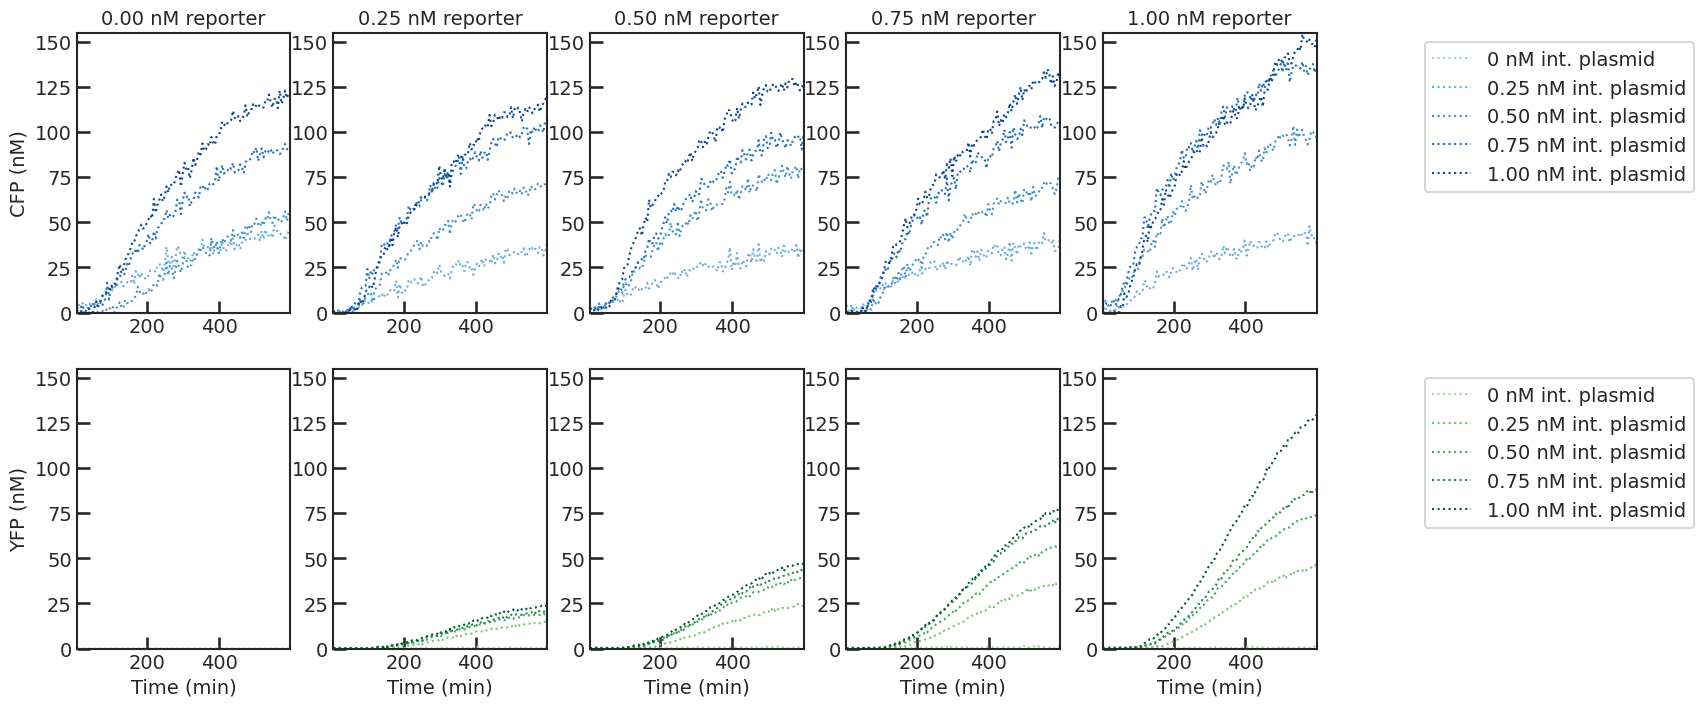

In [9]:
colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']
time_lim = [timepoints[0], timepoints[-1]]
cfp_lim = [0, 155]
yfp_lim = [0, 155]
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
for rep_ind in range(num_reporter_conditions):
    if index == 1:
        axc = fig.add_subplot(2,num_integrase_conditions,index)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5)
    else:
        axc = fig.add_subplot(2,num_integrase_conditions,index, sharey = axc)
        axy = fig.add_subplot(2,num_reporter_conditions,index+5, sharey = axy)
        
    for int_ind in range(num_integrase_conditions):
        # Data
        axc.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'CFP')],
                 color=colorc[int_ind], ls = 'dotted')
        axy.plot(timepoints, expdata_dict[(int_conditions[int_ind] ,rep_conditions[rep_ind],'YFP')]
                 ,color=colory[int_ind], ls = 'dotted')
        # Simulations, if needed
#         axc.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'cfp')],
#                  color=colorc[int_ind] )
#         axy.plot(timepoints, simdata[(int_levels[int_ind] ,rep_levels[rep_ind],'yfp')]
#                  ,color=colory[int_ind])
    
    axc.set_title('%1.2f nM reporter' % (rep_conditions[rep_ind]))
    axc.set_xlim(time_lim)
    axy.set_xlim(time_lim)
    axc.set_ylim(cfp_lim)
    axy.set_ylim(yfp_lim)

    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
        axc.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
        axy.legend(['0 nM int. plasmid', '0.25 nM int. plasmid',
                    '0.50 nM int. plasmid', '0.75 nM int. plasmid',
                    '1.00 nM int. plasmid'],
                   loc='best',bbox_to_anchor=(7.61, 1), fontsize = 14)
    index += 1

fig.tight_layout()


In [10]:
m.get_parameter_dictionary()

{'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05}

In [11]:
# Create a data frame with all the simulated and real results to use here
# as the source for doing parameter inference on the data (simulated or real)
# Columns are string for real or simulated, time, cfp, yfp, int_nm, rep_nm

import pandas as pd
e_df = {'type':[], 'time':[], 'int_nm':[], 'rep_nm':[], 'Int':[], 'YFP':[]}

# add the simulated data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['sim']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(simdata[(int_nm,rep_nm,'cfp')])
        e_df['YFP'].extend(simdata[(int_nm,rep_nm,'yfp')])

# add the real data
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['type'].extend(['exp']*length)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(expdata_dict[(int_nm,rep_nm,'CFP')])
        e_df['YFP'].extend(expdata_dict[(int_nm,rep_nm,'YFP')])

e_df = pd.DataFrame(e_df)

data_file = open('../experimental_data/trace_data_frame.b','wb')
pickle.dump(e_df, data_file)
data_file.close()

In [12]:
initial_conditions = []
all_data = []
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]

for int_nm in int_levels:
    for rep_nm in rep_levels:
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm)) & (e_df['type'] == 'exp')]
        all_data.append(exp_data)

In [13]:
# m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'n': 1.0, 'k': 0.05})

In [14]:
m.get_parameter_dictionary()

{'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05}

In [15]:
# initial_conditions

In [16]:
len(all_data[0]['Int'])

120

In [17]:
m.get_species_dictionary()

{'Int': 0.0, 'A': 0.0, 'YFP': 0.0, 'G_I': 1.0, 'G_tot': 1.0}

## Run parameter inference (step 1):


creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


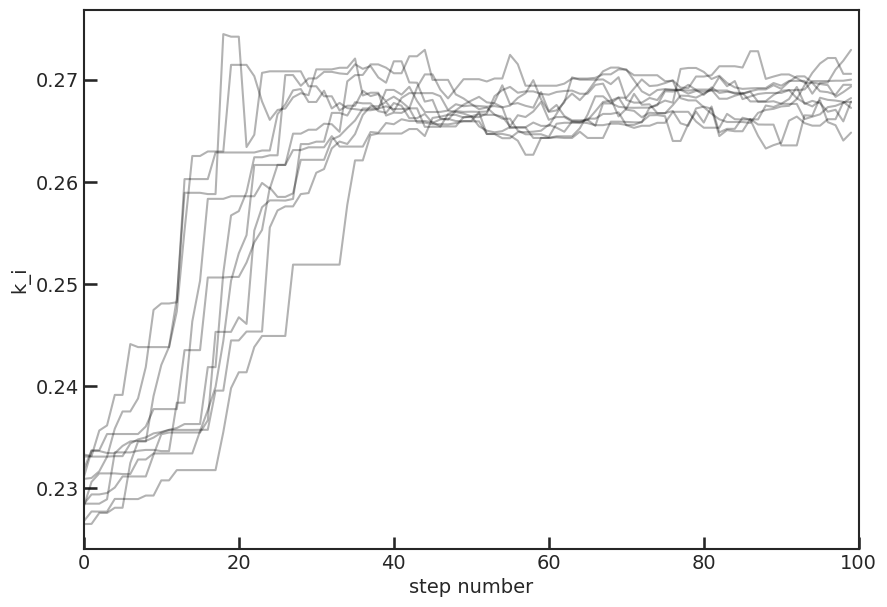

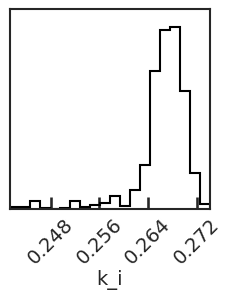

In [18]:
from bioscrape.inference import py_inference

init_values = np.array([0.23])

prior = {'k_i' : ['gaussian', 0.23, 1, 'positive']}
# Increase number of steps and number of walkers to actually run this:
nwalkers = 10
nsteps = 100
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['Int'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)

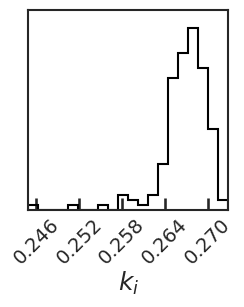

In [21]:
import corner
labels = ['$k_{i}$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
# fig.savefig('../outputs/mcmc_cfp_corner.svg')

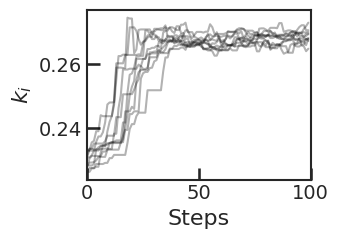

In [22]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,0]
ax.plot(samples, alpha = 0.3, color = 'k')
# ax.set_xlim(0, len(samples))
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_i$', fontsize = 16)
ax.set_xlim([0,nsteps])
fig.tight_layout()
# fig.savefig('../outputs/mcmc_cfp_chain.svg')

Parameter posterior distribution convergence plots:


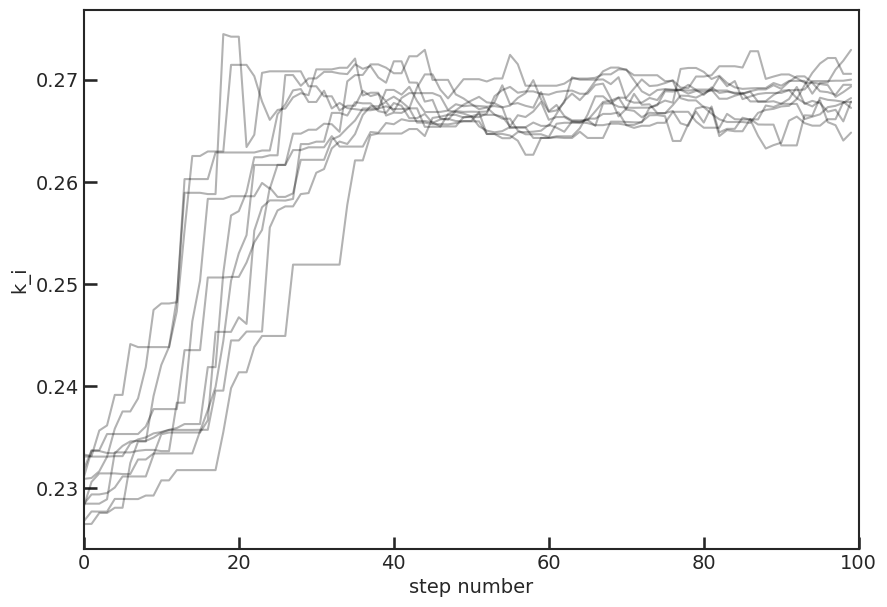

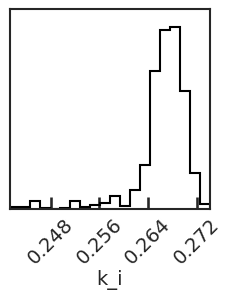

In [23]:
k_i, k_i_error = pid.plot_mcmc_results(sampler)

In [24]:
k_i

{'k_i_true': 0.26723455677644414,
 'k_i_uncertainties': array([0.00264826, 0.00246874])}

In [25]:
m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')

In [26]:
# m.set_parameter('k_i', k_i[0])
m.set_parameter('k_i', 0.2680175639510619)

In [27]:
m.get_parameter_dictionary()

{'k_i': 0.2680175639510619, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05}

In [28]:
m.get_species_dictionary()

{'Int': 0.0, 'A': 0.0, 'YFP': 0.0, 'G_I': 0.0, 'G_tot': 0.0}

In [29]:
initial_conditions = []
all_data = []
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]

for int_nm in int_levels:
    for rep_nm in rep_levels:
        initial_conditions.append({"G_I": int_nm, "G_tot": rep_nm})
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm)) & (e_df['type'] == 'exp')]
        all_data.append(exp_data)

creating an ensemble sampler with multiprocessing pool= None


 32%|███▏      | 32/100 [00:02<00:05, 13.55it/s]/home/codespace/.python/current/lib/python3.10/site-packages/bioscrape/pid_interfaces.py:114: RuntimeWarning: divide by zero encountered in log
  return np.log(prob)
100%|██████████| 100/100 [00:07<00:00, 13.07it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


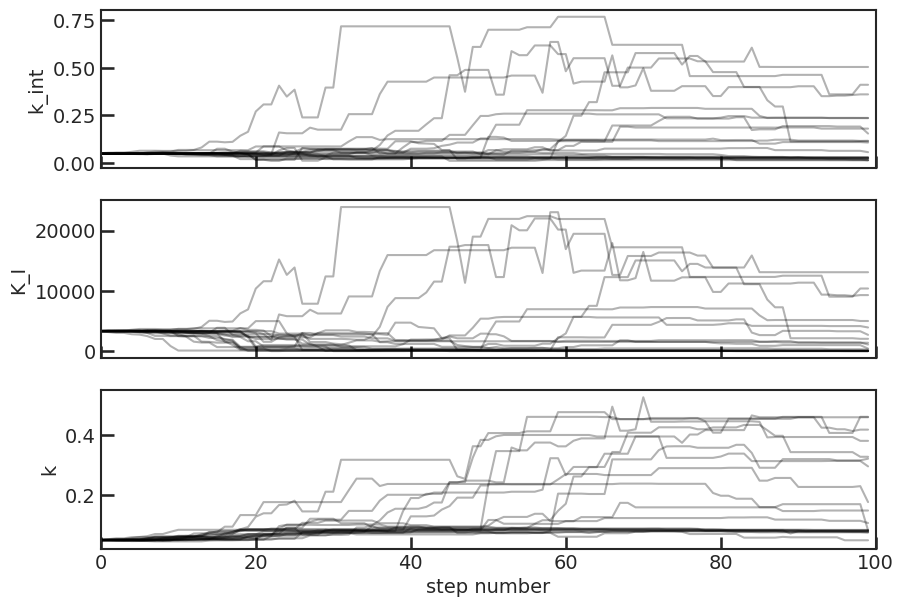

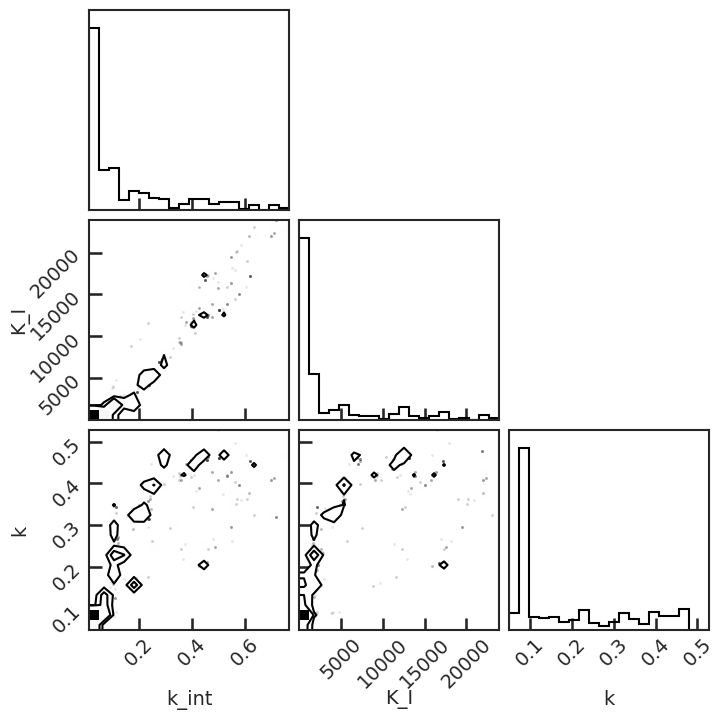

In [30]:
from bioscrape.inference import py_inference

init_values = np.array([0.05,3335,0.05])

prior = {'k_int' : ['gaussian', 0.05, 10, 'positive'],
         'K_I' : ['gaussian', 3330, 1000, 'positive'], #'n' : ['gaussian', 2, 2, 'positive'],
         'k' : ['gaussian', 1e-4, 0.1, 'positive']}
# Increase number of steps and number of walkers to actually run this:
nwalkers = 20
nsteps = 100
sampler, pid = py_inference(Model = m, exp_data = all_data, measurements = ['YFP'], time_column = ['time'],
                            nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                            initial_conditions = initial_conditions, 
                            init_seed = init_values,
                            params_to_estimate = [p for p in prior],
                            prior = prior, convergence_check = False, debug = False)

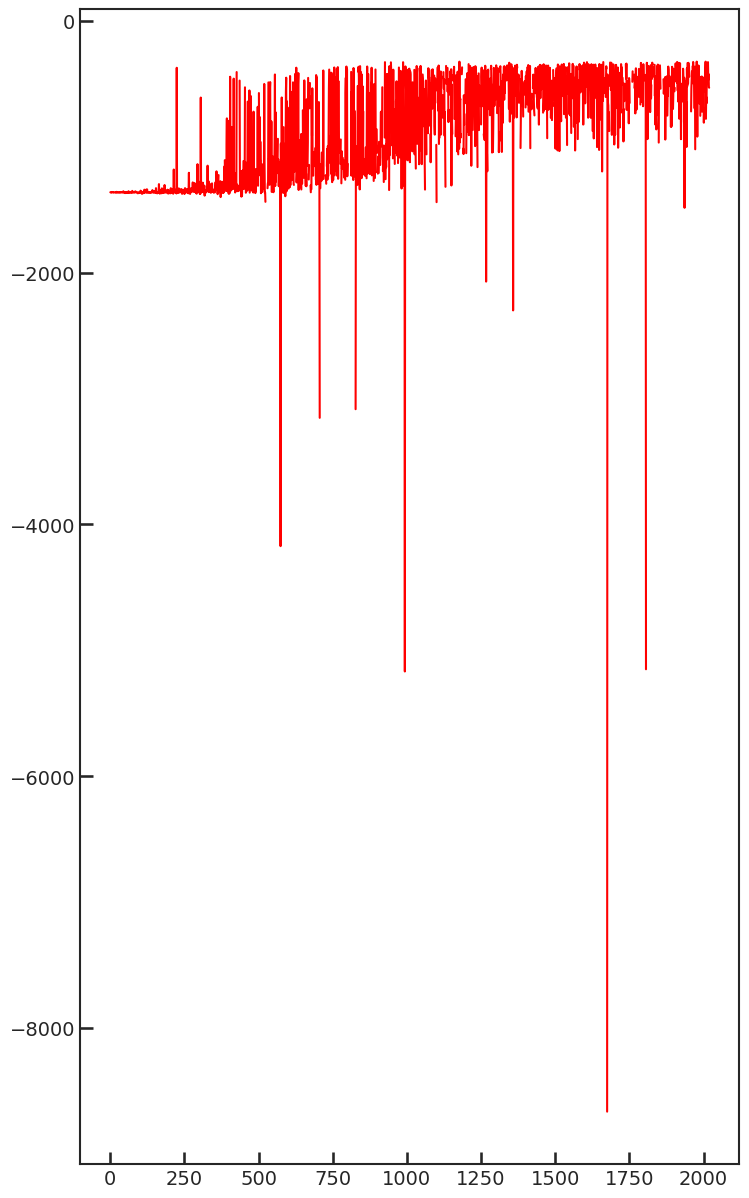

In [31]:
plt.plot(pid.cost_progress)

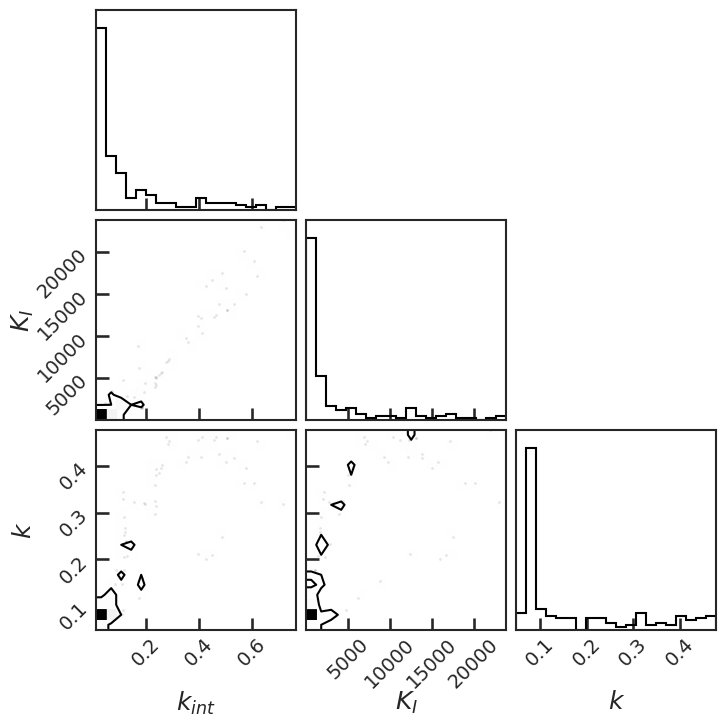

In [32]:
import corner
# labels = ['$k_{int}$', '$K_{I}$', '$n$', '$k$']
labels = ['$k_{int}$', '$K_{I}$', '$k$']
flat_samples = sampler.get_chain(discard=int(.2*nsteps), thin = int(0.5*nwalkers), flat=True)
fig = corner.corner(flat_samples, levels = (0.75,), 
                    labels = labels, use_math_text = False, 
                    label_kwargs = {'fontsize':18})
# fig.savefig('../outputs/mcmc_yfp_corner.svg')

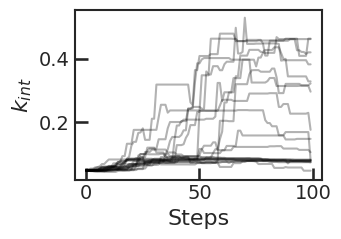

In [33]:
fig, ax = plt.subplots(figsize = (4,3))
samples = sampler.get_chain()[:,:,2]
ax.plot(samples, alpha = 0.3, color = 'k')
ax.set_xlabel('Steps', fontsize = 16)
ax.set_ylabel('$k_{int}$', fontsize = 16)
fig.tight_layout()
# fig.savefig('../outputs/mcmc_yfp_chain_k.svg')

creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 579.70it/s]

Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.


creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 486.88it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 488.14it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 495.68it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 460.45it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 546.17it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 207.72it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 449.61it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 460.44it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 403.66it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 584.95it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 446.33it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 427.13it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 384.66it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 426.66it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 596.12it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 454.60it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 438.79it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 406.00it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 432.43it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 543.66it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 432.59it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 380.67it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 363.24it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
creating an ensemble sampler with multiprocessing pool= None


100%|██████████| 100/100 [00:00<00:00, 430.11it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.


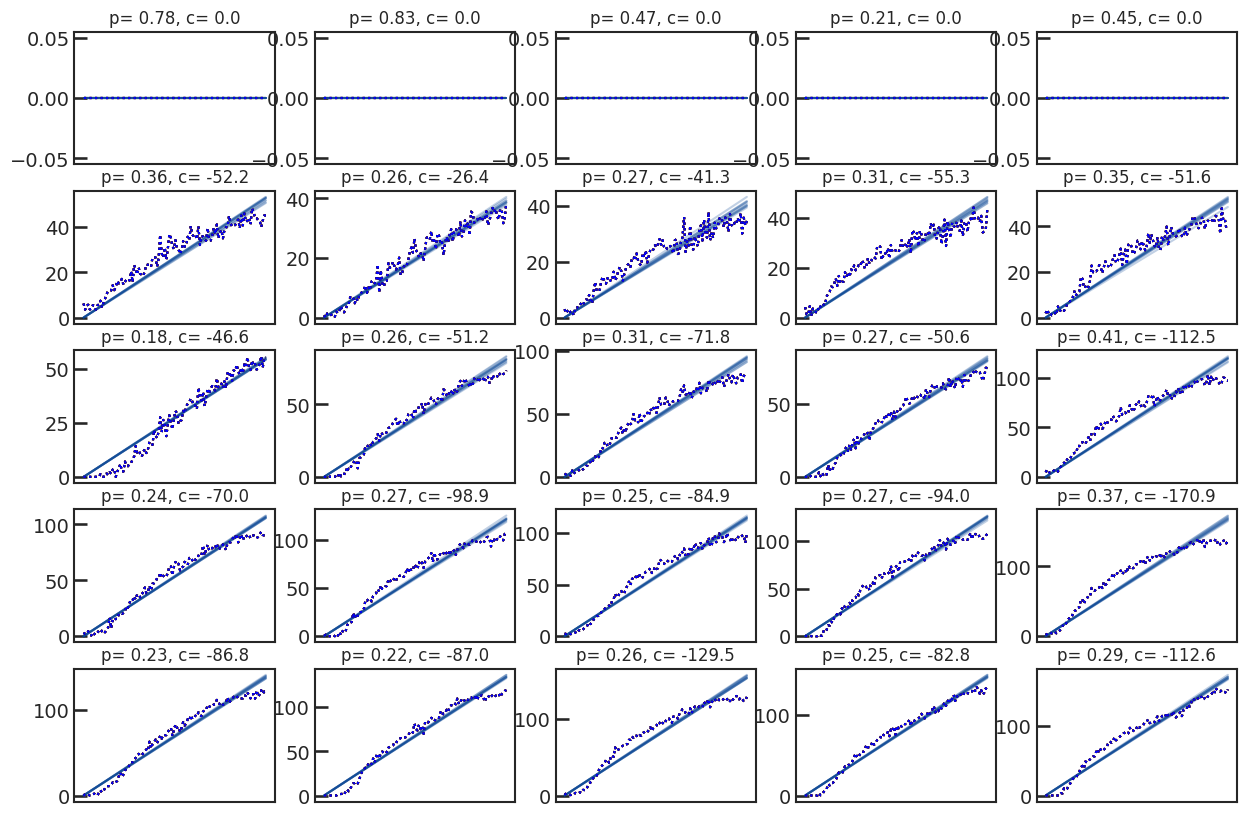

In [34]:
from bioscrape.types import Model
from bioscrape.inference import py_inference
from bioscrape.simulator import py_simulate_model

int_conditions = [0.0,0.25,0.5,0.75,1.]
rep_conditions = [0.0,0.25,0.5,0.75,1.]

num_integrase_conditions = len(int_conditions)
num_reporter_conditions = len(rep_conditions)
e_df = {'time':[], 'int_nm':[], 'rep_nm':[], 'Int':[], 'YFP':[]}
for int_ind, int_nm in zip(range(num_integrase_conditions), int_conditions):
    for rep_ind, rep_nm in zip(range(num_reporter_conditions),rep_conditions):
        length = len(timepoints)
        e_df['time'].extend(timepoints)
        e_df['int_nm'].extend([int_nm]*length)
        e_df['rep_nm'].extend([rep_nm]*length)
        e_df['Int'].extend(expdata_dict[(int_nm,rep_nm,'CFP')])
        e_df['YFP'].extend(expdata_dict[(int_nm,rep_nm,'YFP')])

e_df = pd.DataFrame(e_df)
initial_conditions = []
all_data = []

fig, ax = plt.subplots(nrows = len(int_conditions), ncols = len(rep_conditions), figsize = (15,10))
for rep_nm in rep_conditions:
    for int_nm in int_conditions:
        m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')
#         m.set_params({'k_i': 0.24, 'k_int': 0.05, 'K_I': 3335.0, 'n': 2.0, 'k': 0.05})
        axc = ax[int_conditions.index(int_nm)][rep_conditions.index(rep_nm)]
        initial_conditions = {"G_I": int_nm, "G_tot": rep_nm}
        init_values = np.array([0.23])
        exp_data = e_df.loc[(e_df['int_nm'].eq(int_nm)) & (e_df['rep_nm'].eq(rep_nm))]
        prior = {'k_i' : ['uniform', 0.03, 1, 'positive']}
        # Increase walkers and steps to actually run this
        nwalkers = 10
        nsteps = 100
        sampler, pid = py_inference(Model = m, exp_data = exp_data, measurements = ['Int'], time_column = ['time'],
                                    nwalkers = nwalkers, nsteps = nsteps, sim_type = 'deterministic', 
                                    initial_conditions = initial_conditions, 
                                    init_seed = init_values,
                                    params_to_estimate = [p for p in prior],
                                    prior = prior, convergence_check = False, 
                                    plot_show = False, debug = False)
        flat_samples = sampler.get_chain(discard=int(.5*nsteps), thin = int(0.5*nwalkers), flat=True)
        inds = np.arange(0, len(flat_samples), 1)
        np.random.shuffle(inds)
        inds = inds[:10]
        timepoints = np.array(pid.timepoints)
        for s_ind in inds:
            s = flat_samples[s_ind]
            m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')
            m.set_species({"G_I":int_nm, "G_tot":rep_nm})
            p_array = []
            for pi, pi_val in zip(pid.params_to_estimate, s):
                p_array.append(pi_val)
                m.set_parameter(pi, pi_val)
                results = py_simulate_model(Model = m, timepoints = timepoints);
                axc.plot(timepoints, results["Int"], color = colorc[int_ind], alpha = .25)
                axc.plot(timepoints, expdata_dict[(int_nm ,rep_nm,'CFP')],ls = 'dotted')
            axc.set_title('p= {:.2f}, c= {:0.1f}'.format(np.mean(p_array), np.max(pid.cost_progress)), fontsize = 12)
            axc.set_xticks([])

Text(0.5, 1.0, 'Cost Progress')

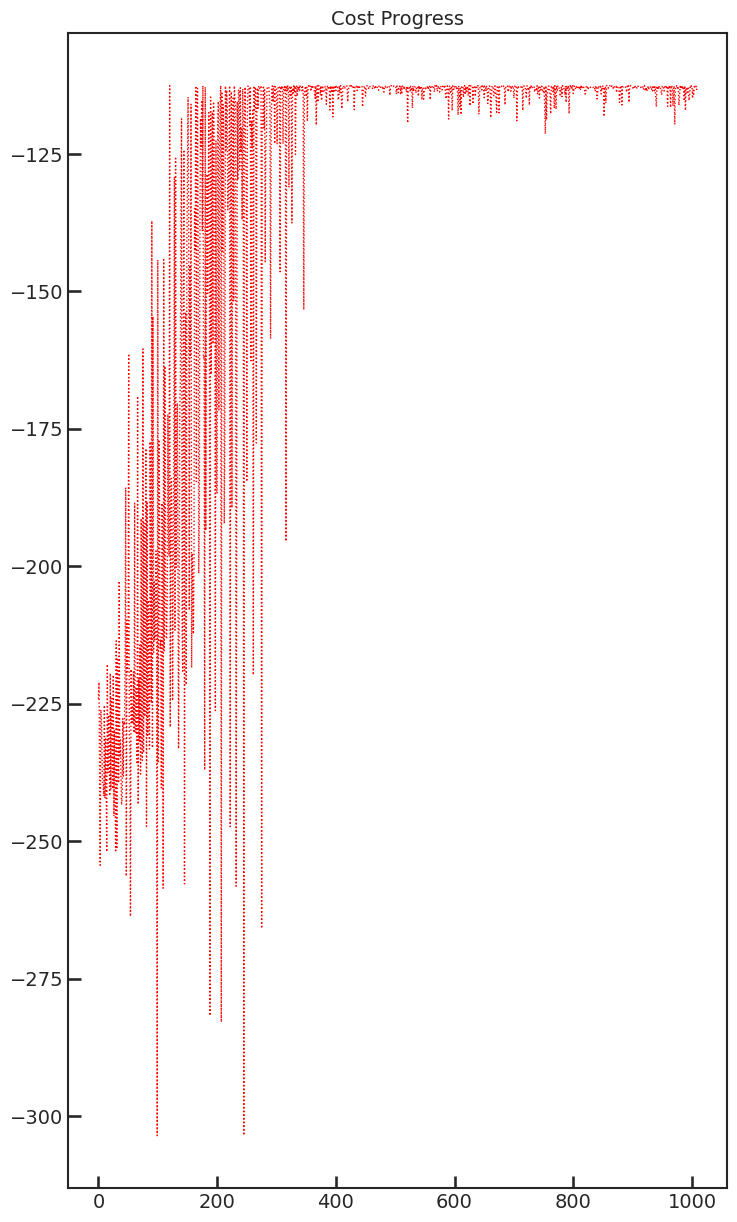

In [35]:
plt.plot(pid.cost_progress, 'r', ls = 'dotted', lw = 1)
plt.title('Cost Progress')

In [37]:
np.max(pid.cost_progress)

-112.58844738937269

## Model simulation with data

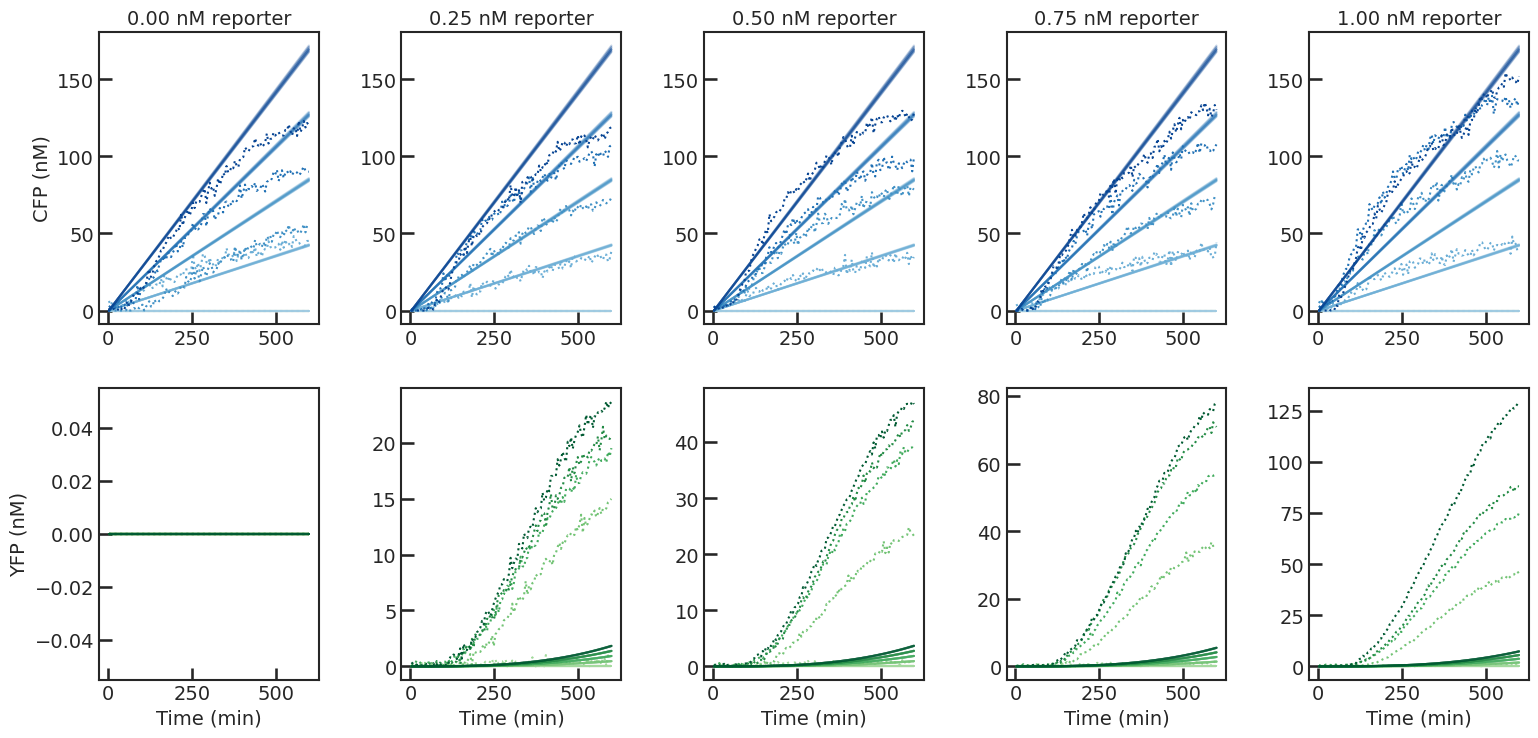

In [40]:
m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')

flat_samples = sampler.get_chain(discard=int(.4*nsteps), thin = int(0.5*nwalkers), flat=True)
inds = np.arange(0, len(flat_samples), 1)
np.random.shuffle(inds)
inds = inds[:10]
tol = 0.1
timepoints = np.array(pid.timepoints)
figsize = (16,8)
fig = plt.figure(figsize=figsize)
index = 1
int_levels = [0.0,0.25,0.5,0.75,1.]
rep_levels = [0.0,0.25,0.5,0.75,1.]
for rep_ind in range(len(int_levels)):
    axc = fig.add_subplot(2,len(int_levels),index)
    axy = fig.add_subplot(2,len(int_levels),index+len(int_levels))
    
    for int_ind in range(len(int_levels)):
        
        for s_ind in inds:
            s = flat_samples[s_ind]
            m.set_species({"G_I":int_levels[int_ind], "G_tot":rep_levels[rep_ind]})
            for pi, pi_val in zip(pid.params_to_estimate, s):
                m.set_parameter(pi, pi_val)
#                 m.set_parameter(pi, 0.13)
            results = py_simulate_model(Model = m, timepoints = timepoints)
            axc.plot(timepoints, results["Int"], color = colorc[int_ind], alpha = .25)
            axy.plot(timepoints, results["YFP"], color = colory[int_ind], alpha = .25)
          
        axc.plot(timepoints, expdata_dict[(int_levels[int_ind] ,rep_levels[rep_ind],'CFP')],
                 color=colorc[int_ind], ls = 'dotted')
        axy.plot(timepoints, expdata_dict[(int_levels[int_ind] ,rep_levels[rep_ind],'YFP')]
                 ,color=colory[int_ind], ls = 'dotted')
    
    axc.set_title('%1.2f nM reporter' % (rep_levels[rep_ind]))
    axy.set_xlabel('Time (min)')
    
    if index == 1:
        axc.set_ylabel('CFP (nM)')
        axy.set_ylabel('YFP (nM)')
    index += 1

fig.tight_layout()

In [41]:
m.get_parameter_dictionary()

{'k_i': 0.2826392087830932, 'k_int': 0.05, 'K_I': 3335.0, 'k': 0.05}

In [45]:
# Generate a dataframe with simulated trajectories from the MCMC results
fc = sampler.get_chain(discard=int(0.5*nsteps), thin=int(0.5*nwalkers), flat = True)
df = {}
df['param_index'] = []
df['Int'] = []
df['YFP'] = []
df['time'] = []
df['rep_nm'] = []
df['int_nm'] = []

# Perform simulations
num_iterations = 5
param_indices = np.random.permutation(np.arange(fc.shape[0]))[:num_iterations]
for param_index in param_indices:
    for rep_nm in [0,0.25,0.5,0.75,1.0]:
        for int_nm in [0,0.25,0.5,0.75,1.0]:  
            m = Model(sbml_filename = '../sbml_files/integrase_sbml_reduced.xml')
            csim = ModelCSimInterface(m)
            c_ind = m.get_species_index('Int')
            y_ind = m.get_species_index('YFP')
            timepoints = pid.timepoints
            csim.py_prep_deterministic_simulation()

            propagator = DeterministicSimulator()
            m.set_species({"G_I": int_nm, "G_tot": rep_nm})
            params = fc[param_index,:]
            # m.set_params({'k_int':params[0], 'K_I':params[1], 'n':params[2], 'k': params[3]})
            m.set_params({'k_i':0.23})
            deterministic = propagator.py_simulate(csim, timepoints)
            
            df['param_index'].extend([param_index]*len(timepoints))
            df['Int'].extend(deterministic.py_get_result()[:,c_ind])
            df['YFP'].extend(deterministic.py_get_result()[:,y_ind])
            df['time'].extend(timepoints)
            df['rep_nm'].extend([rep_nm]*len(timepoints))
            df['int_nm'].extend([int_nm]*len(timepoints))

simdf = pd.DataFrame(df)

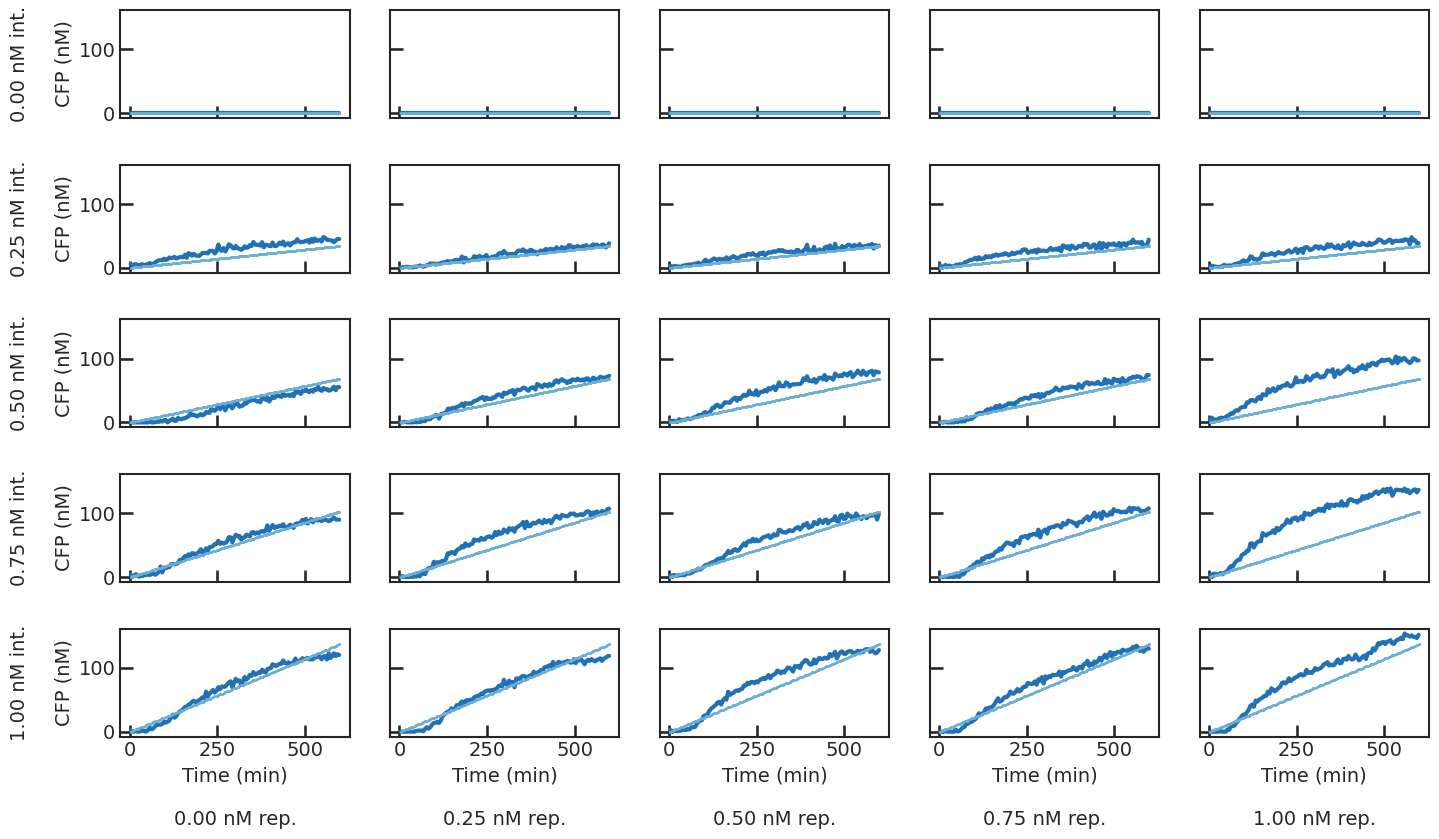

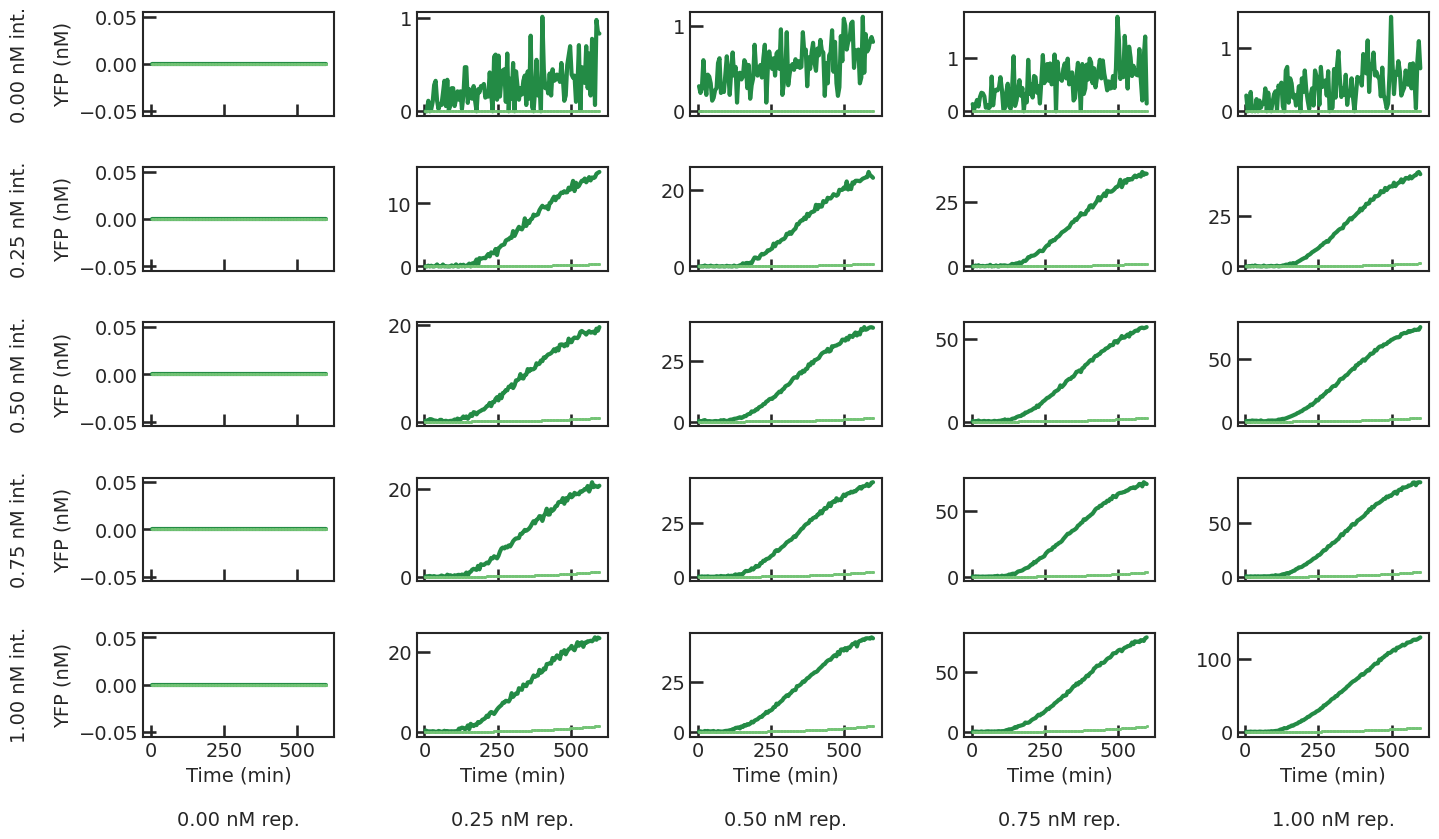

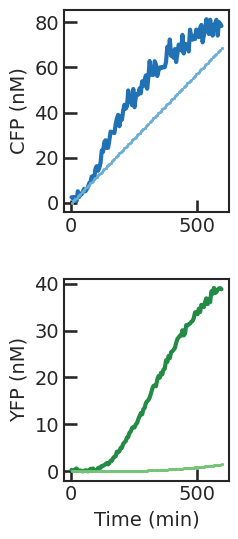

In [47]:
    # Plot the real data

    a = np.array([[1,2],[5,5]])
    np.maximum(a,7)
    colorc = ['#9ecae1','#6baed6','#4292c6', '#2171b5','#084594']
    colory = ['#a1d99b','#74c476','#41ab5d','#238b45','#005a32']

    infile = open('../experimental_data/trace_data_frame.b','rb')
    df = pickle.load(infile)
    infile.close()
    edf = df[df.type == 'exp']

    figsize = (15,9)
    fig, axes = plt.subplots(5,5,figsize=figsize, sharey = True)
    fig2, axes2 = plt.subplots(5,5,figsize=figsize)

    for int_nm in range(5):
        for rep_nm in range(5):
            ax = axes[int_nm,rep_nm]
            ax2 = axes2[int_nm,rep_nm]
            etemp = edf[(edf.int_nm == int_nm/4) & (edf.rep_nm == rep_nm/4)]

            ax.plot(etemp.time,etemp.Int,'-',linewidth=3, color=colorc[3])
            ax2.plot(etemp.time,etemp.YFP,'-',linewidth=3,color=colory[3])
            stemp = simdf[(simdf.int_nm == int_nm/4) & (simdf.rep_nm == rep_nm/4)]
            ax.plot(stemp.time, stemp.Int, '.',color = colorc[1], markersize = 2, alpha= 0.5)
            ax2.plot(stemp.time, stemp.YFP, '.',color = colory[1], markersize = 2, alpha= 0.5)

            if int_nm == 4:
                ax.set_xlabel('Time (min)\n\n%.2f nM rep.' % (rep_nm/4))
                ax2.set_xlabel('Time (min)\n\n%.2f nM rep.' % (rep_nm/4))
            else:
                ax.set_xticklabels([])
                ax2.set_xticklabels([])
            if rep_nm == 0:
                ax.set_ylabel('%.2f nM int.\n\nCFP (nM)' % (int_nm/4))
                ax2.set_ylabel('%.2f nM int.\n\nYFP (nM)' % (int_nm/4))

    fig.tight_layout()
#     fig.savefig('../outputs/model-data-cfp.svg')
    fig2.tight_layout()
    # fig2.savefig('../outputs/model-data-yfp.svg')
    # Plot of matches.
    figsize = (3, 6)
    fig, axes = plt.subplots(2,1,figsize=figsize)

    ax = axes[0]
    ax2 = axes[1]
    etemp = edf[(edf.int_nm == .5) & (edf.rep_nm == .5)]

    ax.plot(etemp.time,etemp.Int,'-',linewidth=3, color=colorc[3])

    ax2.plot(etemp.time,etemp.YFP,'-',linewidth=3,color=colory[3])
    stemp = simdf[(simdf.int_nm == .5) & (simdf.rep_nm == .5)]
    ax.plot(stemp.time, stemp.Int, '.',color = colorc[1], markersize = 2, alpha= 0.5)
    ax2.plot(stemp.time, stemp.YFP, '.',color = colory[1], markersize = 2, alpha= 0.5)

    ax2.set_xlabel('Time (min)')
    ax2.set_ylabel('YFP (nM)')
    ax.set_ylabel('CFP (nM)')
    fig.tight_layout()

Note that the YFP data does not fit the model. This is due to how the parameter inference was setup in this demonstrative example. The number of steps need to be increased and appropriate parameters must be identified.

Last updated by Ayush Pandey on 7th April 2023.